Script that takes nr data files, take signal in our direction, taper the start, propagate to the detectors, add noise, inject into detectors, plot.

First some imports

In [1]:
import bilby 
from bilby.core.prior import Uniform
from bilby.gw.utils import asd_from_freq_series

import numpy as np
import matplotlib
matplotlib.use("Qt5Agg") 
import matplotlib.pyplot as plt
%matplotlib widget
import h5py
import lalsimulation as lalsim
import lal
import os

from scipy.interpolate import UnivariateSpline
from scipy.optimize import root_scalar


/home/selmavangstein/miniconda3/envs/ringdown/lib/python3.11/site-packages/lalsimulation/lalsimulation.py:8: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(False)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  import lal


Define some helpers:

In [2]:
#some inverse fourier transform helper 
def infft(frequency_domain_strain, sampling_frequency, length=None):
    """ Inverse FFT for use in conjunction with nfft.

    Parameters
    ----------
    frequency_domain_strain: array_like
        Single-sided, normalised FFT of the time-domain strain data (in units
        of strain / Hz).
    sampling_frequency: int, float
        Sampling frequency of the data.
    length: float
        length of the transformed axis of the output.
    """

    time_domain_strain_norm = np.fft.irfft(frequency_domain_strain, n=length)
    time_domain_strain = time_domain_strain_norm * sampling_frequency
    return time_domain_strain


#interpolating to fit our time array
def nr_injection(time):
    """
    This function produces the amplitude for a given 
    NR-derived signal at any given time for a given data file.
    
    Parameters
    ----------
    time : array-like
        A time, or an array of times, at which the amplitudes should be returned.
    datafile : str
        The path to the data file containing the injection.
    """
    
    hp = np.interp(time, times, h_p.data.data)
    hc = np.interp(time, times, h_c.data.data)
    
    return {"plus": hp, "cross": hc}

Some bibly overhead

In [3]:
# Specify the output directory and the name of the simulation.
# bilby setup stuff
outdir = "outdir"
label = "phenomXP"
bilby.core.utils.setup_logger(outdir=outdir, label=label)

Set parameters from NR injection waveform

In [4]:
# Set the binary parameters of the NR inejection waveform
# this is the angle and distance to the source
inclination = 0 #!!!this needs to be 0 for tapering calc
luminosity_distance = 250.
distance = luminosity_distance * lal.PC_SI * 1.0e6
phiRef = 0.0

# our relevant file path - create separate folder system
filepath = 'chombo/GRChombo_BBSsol02_A147A147q100d12p000_Res40.h5'
#filepath = 'chombo/GRChombo_BBSsol02_A17A17q100d17p000_Res40.h5'
#filepath = 'grav_wave_boson_star_testing_gr/GRChombo_BBSsol02_A147A147q100d12p000_Res40.h5'
f = h5py.File(filepath, 'r')

Set up dictionary to store parameters. Populate it

In [5]:
# setting up dict to feed parameters into waveforms
params = lal.CreateDict()
lalsim.SimInspiralWaveformParamsInsertNumRelData(params, filepath)

# Metadata parameters masses
mtotal = 40.0 # set total mass scale - sim only has relative
# extract masses and convert to different units
m1 = f.attrs['mass1'] #code units
m2 = f.attrs['mass2']

mass_1 = m1 * mtotal / (m1 + m2) #solar masses
mass_2 = m2 * mtotal / (m1 + m2)

# Choose extrinsic parameters

m1SI = mass_1 * lal.MSUN_SI #in kg
m2SI = mass_2 * lal.MSUN_SI

spins = lalsim.SimInspiralNRWaveformGetSpinsFromHDF5File(0., mtotal, filepath)
s1x, s1y, s1z = spins[0], spins[1], spins[2]
s2x, s2y, s2z = spins[3], spins[4], spins[5]

# Set sampling frequency of the data segment that we're going to inject the signal into
# just be aware of aliasing issues if too low
sampling_frequency = 4096.0  # Hz
deltaT = 1.0/sampling_frequency #cadence

# we need to set the lowest trustable frequency - set as lowest simulated frequency, scaled by the chosen mass
#CHANGE THIS AFTER DOING THE TAPERING
f_lower = f.attrs['f_lower_at_1MSUN']/mtotal  # this choice generates the whole NR waveforms from the beginning
fRef = 0   #beginning of the waveform
fStart = f_lower


In [6]:
f.close()

Use `lalsim` to generate the waveform polarisations for the injection.

In [7]:
params = lal.CreateDict()
lalsim.SimInspiralWaveformParamsInsertNumRelData(params, filepath)

approx = lalsim.NR_hdf5

inject_l_modes=[2]
ModeArray = lalsim.SimInspiralCreateModeArray()
for mode in inject_l_modes:
    lalsim.SimInspiralModeArrayActivateAllModesAtL(ModeArray, mode)

lalsim.SimInspiralWaveformParamsInsertModeArray(params, ModeArray)

h_p, h_c = lalsim.SimInspiralChooseTDWaveform(m1SI, m2SI, s1x, s1y, s1z,
                s2x, s2y, s2z, distance, inclination, phiRef, np.pi/2., 0.0, 0.0, 
                deltaT, fStart, fRef, params, approx)

times = np.arange(len(h_p.data.data))*h_p.deltaT

In [8]:
#EDIT THIS TO DO DIFFERENT SAFETIES

phase = np.arctan2(h_c.data.data, h_p.data.data)
unwrapped_phase = np.unwrap(phase)
unwrapped_phase_interp = UnivariateSpline(times, unwrapped_phase, k=3, s=0)
omega_interp = unwrapped_phase_interp.derivative() 
frequency = omega_interp(times) / (2.0 * np.pi)


safeties = [0.1, 0.2, 0.5, 0.8]
minimum_frequencies = []
times_list = []
for safety in safeties:
    sol = root_scalar(lambda t1: (1+safety)*(1./t1)-omega_interp(t1)/(2.0*np.pi),
                        x0 = 0.1, 
                        bracket=[0.01, 0.3])
    t0, t1 = 0., sol.root
    f0, f1 = omega_interp(t0)/(2.0*np.pi), omega_interp(t1)/(2.0*np.pi)
    print(f"{t0=:.2e}, {f0=:.2e}, {t1=:.2e}, {f1=:.2e}")

    minimum_frequency = f1
    minimum_frequencies.append(minimum_frequency)
    times_list.append((t0, t1))



t0=0.00e+00, f0=2.66e+01, t1=4.09e-02, f1=2.69e+01
t0=0.00e+00, f0=2.66e+01, t1=4.42e-02, f1=2.71e+01
t0=0.00e+00, f0=2.66e+01, t1=5.48e-02, f1=2.74e+01
t0=0.00e+00, f0=2.66e+01, t1=6.45e-02, f1=2.79e+01


In [9]:
from scipy.signal import windows

def window(times, t0, t1, kind='cosine'):
    taper = np.ones_like(times)
    mask = (times >= t0) & (times <= t1)
    x = (times[mask] - t0) / (t1 - t0) # Normalized [0, 1] range

    if kind == 'cosine':
        taper[mask] = 0.5 * (1 - np.cos(np.pi * x))

    elif kind == "plancktaper":
        taper[mask] = np.array([
            1 / (np.exp((1 / xi) - (1 / (1 - xi))) + 1)
            if xi < 1 else 1.0
            for xi in x
        ])
    
    else:
        # Generate a standard SciPy window and take only the first half
        n = np.count_nonzero(mask)
        try:
            wfunc = getattr(windows, kind)
            w = wfunc(n * 2)[:n] 
            w /= w.max()
            taper[mask] = w
        except AttributeError:
            raise ValueError(f"Unknown window type '{kind}'")

    return taper

In [10]:
window_funcs = ['cosine', 'plancktaper', 'hann', 'blackman', 'nuttall']
# cosine: 0.5 * (1 - np.cos(np.pi * x))
# plack-taper: 1 / (np.exp((1 / x) - (1 / (1 - x))) + 1)  if x < 1 else 1.0
# hann: 0.5 * (1 - cos(2 * pi * x / (N - 1)))
# blackman: 0.42 - 0.5 * cos(2 * pi * x / (N - 1)) + 0.08 * cos(4 * pi * x / (N - 1))
# nuttall: 0.355768 - 0.487396 * cos(2 * pi * x / (N - 1)) + 0.144232 * cos(4 * pi * x / (N - 1)) - 0.012604 * cos(6 * pi * x / (N - 1))
# N: length of the window


# create storage dicts
taper_dict = {}        
tapered_hp_dict = {}   
tapered_hc_dict = {}

for i, safety in enumerate(safeties):
    t0, t1 = times_list[i]
    for func in window_funcs:
        taper = window(times, t0, t1, kind=func)
        taper_dict[(safety, func)] = taper

        # apply to signals
        tapered_hp = h_p.data.data * taper
        tapered_hc = h_c.data.data * taper
        tapered_hp_dict[(safety, func)] = tapered_hp
        tapered_hc_dict[(safety, func)] = tapered_hc

/tmp/ipykernel_97207/555377284.py:13: RuntimeWarning: divide by zero encountered in scalar divide
  1 / (np.exp((1 / xi) - (1 / (1 - xi))) + 1)


We plot the results

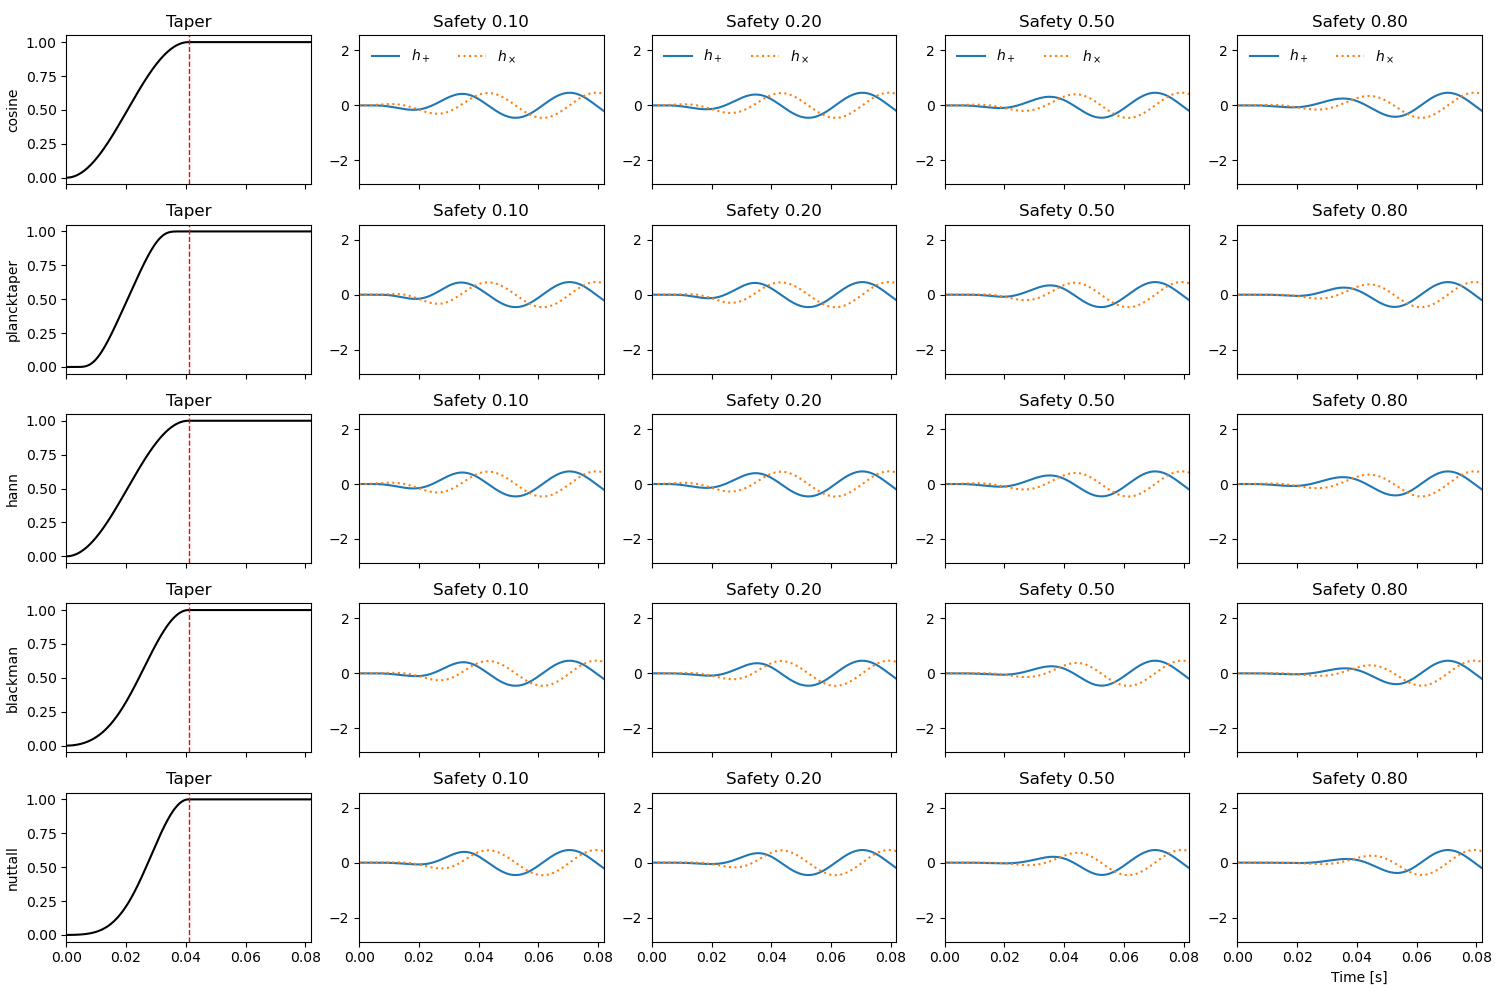

In [11]:
import matplotlib.pyplot as plt

n_rows = len(window_funcs)
n_cols = len(safeties) + 1  # first column = taper, rest = tapered signals

fig, axes = plt.subplots(n_rows, n_cols, figsize=(3*n_cols, 2*n_rows), sharex=True)

for row, func in enumerate(window_funcs):
    # First column: taper function
    # Pick the first safety for plotting the taper itself (or average over safeties)
    first_safety = safeties[0]
    t0, t1 = times_list[0]
    taper_function = taper_dict[(first_safety, func)]
    axes[row, 0].plot(times, taper_function, 'k-')
    axes[row, 0].set_xlim(t0, t1*2)
    axes[row, 0].set_ylabel(func)
    axes[row, 0].set_title("Taper")
    #add vertical line at t=t1
    axes[row, 0].axvline(t1, color='r', ls='--', lw=1)

    # Other columns: tapered data
    for col, safety in enumerate(safeties, start=1):
        hp = tapered_hp_dict[(safety, func)]
        hc = tapered_hc_dict[(safety, func)]
        axes[row, col].plot(times, 1e21*hp, ls='-', label=r'$h_+$')
        axes[row, col].plot(times, 1e21*hc, ls=':', label=r'$h_\times$')
        axes[row, col].set_title(f"Safety {safety:.2f}")
        if row == 0:
            axes[row, col].legend(loc='upper left', frameon=False, ncols=2)

plt.xlabel("Time [s]")
plt.tight_layout()
plt.show()


Now we need to figure out how to replace this data in h_p.data.data and h_c.data.data

In [12]:
# Replace the waveform data in-place with the tapered arrays
original_hp = np.copy(h_p.data.data)
original_hc = np.copy(h_c.data.data)
tapered_data_dict = {}

# we now run the whole bilby injection on each of the tapered datasets in the dictionary
# run a test on two first safeties and two window functions
for safety in safeties:
    print("Working on safety: ", safety)
    for func in window_funcs:
        print("  Using window function: ", func)
        tapered_hp = tapered_hp_dict[(safety, func)]
        tapered_hc = tapered_hc_dict[(safety, func)]
        h_p.data.data[:] = tapered_hp
        h_c.data.data[:] = tapered_hc
        
        amplitude = []

        #print(" finding peak amplitude... (might take some time)")
        for i in range(len(h_p.data.data)):
            amp = np.sqrt(h_p.data.data[i] * h_p.data.data[i] + h_c.data.data[i] * h_c.data.data[i])
            amplitude.append(amp)
            
        peak_id = amplitude.index(max(amplitude))
        peak = times[peak_id]

        #print(" I am at peak at value: ", peak)

        hplus = h_p.data.data[peak_id]
        hcross = h_c.data.data[peak_id]
        #print(" hplus at peak: ", hplus)
        #print(" hcross at peak: ", hcross)

        # the phase when they merge
        phase_merger = np.arctan2(-hcross,hplus) + np.pi

        #print(" arctan(-hcross/hplus): ", np.arctan2(-hcross,hplus))
        #print(" Phase at coalescence: ", phase_merger)

        # Set the duration of the data segment that we're
        # going to inject the signal into
        duration = times[-1]
        #print(" Duration of the signal equals: ", duration)

        # Set up a random seed for result reproducibility.  This is optional!
        np.random.seed(88170235)

        # We first establish a  dictionary of parameters that includes all of the different waveform
        # parameters, including masses (mass_1, mass_2),  spins (a, tilt, phi), etc.
        # this is to create the signal propagating through the detectors
        injection_parameters = dict(
            mass_1=mass_1,
            mass_2=mass_2,
            a_1=0.0,
            a_2=0.0,
            tilt_1=0.0,
            tilt_2=0.0,
            phi_12=0.0,
            phi_jl=0.0,
            luminosity_distance=luminosity_distance,
            theta_jn=inclination,
            psi=np.pi/2,
            phase=phase_merger,
            geocent_time=peak,
            ra=1.375,
            dec=-1.2108)
        
        # create signal as it reaches the detectors / propagate signal to detectors
        # call the waveform_generator to create our waveform model.
        #print(" propagating signal to detectors...")
        waveform = bilby.gw.waveform_generator.WaveformGenerator(duration=duration, sampling_frequency=sampling_frequency,
            time_domain_source_model=nr_injection, start_time=0.0);

        # get out the strain in the time and frequency domains
        time_domain = waveform.time_domain_strain(parameters=injection_parameters);
        time_array = waveform.time_array

        fr_domain = waveform.frequency_domain_strain(parameters=injection_parameters);
        fr_array = waveform.frequency_array

        #print(" injecting signal into detectors...")
        # inject the signal into three interferometers and add noise
        ifos = bilby.gw.detector.InterferometerList(['H1', 'L1']);
        ifos.set_strain_data_from_power_spectral_densities(
            sampling_frequency=sampling_frequency, duration=duration,
            start_time=0.);
        ifos.inject_signal(waveform_generator=waveform,
                        parameters=injection_parameters, raise_error=False);

        #store results ifos data in a tapered data dict to create time series data later
        tapered_data_dict[(safety, func)] = ifos


        

Working on safety:  0.1
  Using window function:  cosine


15:51 bilby INFO    : Waveform generator instantiated: WaveformGenerator(duration=0.453369140625, sampling_frequency=4096.0, start_time=0.0, frequency_domain_source_model=None, time_domain_source_model=__main__.nr_injection, parameter_conversion=bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters, waveform_arguments={})
15:51 bilby WARNING : The injected signal has a duration in-band of 1.9s, but the data for detector H1 has a duration of 0.453369140625s
15:51 bilby INFO    : Injected signal in H1:
15:51 bilby INFO    :   optimal SNR = 70.14
15:51 bilby INFO    :   matched filter SNR = 70.86+0.76j
15:51 bilby INFO    :   mass_1 = 20.0
15:51 bilby INFO    :   mass_2 = 20.0
15:51 bilby INFO    :   a_1 = 0.0
15:51 bilby INFO    :   a_2 = 0.0
15:51 bilby INFO    :   tilt_1 = 0.0
15:51 bilby INFO    :   tilt_2 = 0.0
15:51 bilby INFO    :   phi_12 = 0.0
15:51 bilby INFO    :   phi_jl = 0.0
15:51 bilby INFO    :   luminosity_distance = 250.0
15:51 bilby INFO    :   theta_jn = 0
15

  Using window function:  plancktaper


15:52 bilby INFO    : Waveform generator instantiated: WaveformGenerator(duration=0.453369140625, sampling_frequency=4096.0, start_time=0.0, frequency_domain_source_model=None, time_domain_source_model=__main__.nr_injection, parameter_conversion=bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters, waveform_arguments={})
15:52 bilby WARNING : The injected signal has a duration in-band of 1.9s, but the data for detector H1 has a duration of 0.453369140625s
15:52 bilby INFO    : Injected signal in H1:
15:52 bilby INFO    :   optimal SNR = 70.15
15:52 bilby INFO    :   matched filter SNR = 71.78-0.65j
15:52 bilby INFO    :   mass_1 = 20.0
15:52 bilby INFO    :   mass_2 = 20.0
15:52 bilby INFO    :   a_1 = 0.0
15:52 bilby INFO    :   a_2 = 0.0
15:52 bilby INFO    :   tilt_1 = 0.0
15:52 bilby INFO    :   tilt_2 = 0.0
15:52 bilby INFO    :   phi_12 = 0.0
15:52 bilby INFO    :   phi_jl = 0.0
15:52 bilby INFO    :   luminosity_distance = 250.0
15:52 bilby INFO    :   theta_jn = 0
15

  Using window function:  hann


15:53 bilby INFO    : Waveform generator instantiated: WaveformGenerator(duration=0.453369140625, sampling_frequency=4096.0, start_time=0.0, frequency_domain_source_model=None, time_domain_source_model=__main__.nr_injection, parameter_conversion=bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters, waveform_arguments={})
15:53 bilby WARNING : The injected signal has a duration in-band of 1.9s, but the data for detector H1 has a duration of 0.453369140625s
15:53 bilby INFO    : Injected signal in H1:
15:53 bilby INFO    :   optimal SNR = 70.14
15:53 bilby INFO    :   matched filter SNR = 69.95+0.94j
15:53 bilby INFO    :   mass_1 = 20.0
15:53 bilby INFO    :   mass_2 = 20.0
15:53 bilby INFO    :   a_1 = 0.0
15:53 bilby INFO    :   a_2 = 0.0
15:53 bilby INFO    :   tilt_1 = 0.0
15:53 bilby INFO    :   tilt_2 = 0.0
15:53 bilby INFO    :   phi_12 = 0.0
15:53 bilby INFO    :   phi_jl = 0.0
15:53 bilby INFO    :   luminosity_distance = 250.0
15:53 bilby INFO    :   theta_jn = 0
15

  Using window function:  blackman


15:54 bilby INFO    : Waveform generator instantiated: WaveformGenerator(duration=0.453369140625, sampling_frequency=4096.0, start_time=0.0, frequency_domain_source_model=None, time_domain_source_model=__main__.nr_injection, parameter_conversion=bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters, waveform_arguments={})
15:54 bilby WARNING : The injected signal has a duration in-band of 1.9s, but the data for detector H1 has a duration of 0.453369140625s
15:54 bilby INFO    : Injected signal in H1:
15:54 bilby INFO    :   optimal SNR = 70.12
15:54 bilby INFO    :   matched filter SNR = 70.91-1.33j
15:54 bilby INFO    :   mass_1 = 20.0
15:54 bilby INFO    :   mass_2 = 20.0
15:54 bilby INFO    :   a_1 = 0.0
15:54 bilby INFO    :   a_2 = 0.0
15:54 bilby INFO    :   tilt_1 = 0.0
15:54 bilby INFO    :   tilt_2 = 0.0
15:54 bilby INFO    :   phi_12 = 0.0
15:54 bilby INFO    :   phi_jl = 0.0
15:54 bilby INFO    :   luminosity_distance = 250.0
15:54 bilby INFO    :   theta_jn = 0
15

  Using window function:  nuttall


15:54 bilby INFO    : Waveform generator instantiated: WaveformGenerator(duration=0.453369140625, sampling_frequency=4096.0, start_time=0.0, frequency_domain_source_model=None, time_domain_source_model=__main__.nr_injection, parameter_conversion=bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters, waveform_arguments={})
15:54 bilby WARNING : The injected signal has a duration in-band of 1.9s, but the data for detector H1 has a duration of 0.453369140625s
15:54 bilby INFO    : Injected signal in H1:
15:54 bilby INFO    :   optimal SNR = 70.12
15:54 bilby INFO    :   matched filter SNR = 71.22-1.31j
15:54 bilby INFO    :   mass_1 = 20.0
15:54 bilby INFO    :   mass_2 = 20.0
15:54 bilby INFO    :   a_1 = 0.0
15:54 bilby INFO    :   a_2 = 0.0
15:54 bilby INFO    :   tilt_1 = 0.0
15:54 bilby INFO    :   tilt_2 = 0.0
15:54 bilby INFO    :   phi_12 = 0.0
15:54 bilby INFO    :   phi_jl = 0.0
15:54 bilby INFO    :   luminosity_distance = 250.0
15:54 bilby INFO    :   theta_jn = 0
15

Working on safety:  0.2
  Using window function:  cosine


15:55 bilby INFO    : Waveform generator instantiated: WaveformGenerator(duration=0.453369140625, sampling_frequency=4096.0, start_time=0.0, frequency_domain_source_model=None, time_domain_source_model=__main__.nr_injection, parameter_conversion=bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters, waveform_arguments={})
15:55 bilby WARNING : The injected signal has a duration in-band of 1.9s, but the data for detector H1 has a duration of 0.453369140625s
15:55 bilby INFO    : Injected signal in H1:
15:55 bilby INFO    :   optimal SNR = 70.13
15:55 bilby INFO    :   matched filter SNR = 68.07+0.57j
15:55 bilby INFO    :   mass_1 = 20.0
15:55 bilby INFO    :   mass_2 = 20.0
15:55 bilby INFO    :   a_1 = 0.0
15:55 bilby INFO    :   a_2 = 0.0
15:55 bilby INFO    :   tilt_1 = 0.0
15:55 bilby INFO    :   tilt_2 = 0.0
15:55 bilby INFO    :   phi_12 = 0.0
15:55 bilby INFO    :   phi_jl = 0.0
15:55 bilby INFO    :   luminosity_distance = 250.0
15:55 bilby INFO    :   theta_jn = 0
15

  Using window function:  plancktaper


15:56 bilby INFO    : Waveform generator instantiated: WaveformGenerator(duration=0.453369140625, sampling_frequency=4096.0, start_time=0.0, frequency_domain_source_model=None, time_domain_source_model=__main__.nr_injection, parameter_conversion=bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters, waveform_arguments={})
15:56 bilby WARNING : The injected signal has a duration in-band of 1.9s, but the data for detector H1 has a duration of 0.453369140625s
15:56 bilby INFO    : Injected signal in H1:
15:56 bilby INFO    :   optimal SNR = 70.14
15:56 bilby INFO    :   matched filter SNR = 69.79+1.51j
15:56 bilby INFO    :   mass_1 = 20.0
15:56 bilby INFO    :   mass_2 = 20.0
15:56 bilby INFO    :   a_1 = 0.0
15:56 bilby INFO    :   a_2 = 0.0
15:56 bilby INFO    :   tilt_1 = 0.0
15:56 bilby INFO    :   tilt_2 = 0.0
15:56 bilby INFO    :   phi_12 = 0.0
15:56 bilby INFO    :   phi_jl = 0.0
15:56 bilby INFO    :   luminosity_distance = 250.0
15:56 bilby INFO    :   theta_jn = 0
15

  Using window function:  hann


15:57 bilby INFO    : Waveform generator instantiated: WaveformGenerator(duration=0.453369140625, sampling_frequency=4096.0, start_time=0.0, frequency_domain_source_model=None, time_domain_source_model=__main__.nr_injection, parameter_conversion=bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters, waveform_arguments={})
15:57 bilby WARNING : The injected signal has a duration in-band of 1.9s, but the data for detector H1 has a duration of 0.453369140625s
15:57 bilby INFO    : Injected signal in H1:
15:57 bilby INFO    :   optimal SNR = 70.13
15:57 bilby INFO    :   matched filter SNR = 70.28-0.62j
15:57 bilby INFO    :   mass_1 = 20.0
15:57 bilby INFO    :   mass_2 = 20.0
15:57 bilby INFO    :   a_1 = 0.0
15:57 bilby INFO    :   a_2 = 0.0
15:57 bilby INFO    :   tilt_1 = 0.0
15:57 bilby INFO    :   tilt_2 = 0.0
15:57 bilby INFO    :   phi_12 = 0.0
15:57 bilby INFO    :   phi_jl = 0.0
15:57 bilby INFO    :   luminosity_distance = 250.0
15:57 bilby INFO    :   theta_jn = 0
15

  Using window function:  blackman


15:57 bilby INFO    : Waveform generator instantiated: WaveformGenerator(duration=0.453369140625, sampling_frequency=4096.0, start_time=0.0, frequency_domain_source_model=None, time_domain_source_model=__main__.nr_injection, parameter_conversion=bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters, waveform_arguments={})
15:57 bilby WARNING : The injected signal has a duration in-band of 1.9s, but the data for detector H1 has a duration of 0.453369140625s
15:57 bilby INFO    : Injected signal in H1:
15:57 bilby INFO    :   optimal SNR = 70.11
15:57 bilby INFO    :   matched filter SNR = 70.90+0.26j
15:57 bilby INFO    :   mass_1 = 20.0
15:57 bilby INFO    :   mass_2 = 20.0
15:57 bilby INFO    :   a_1 = 0.0
15:57 bilby INFO    :   a_2 = 0.0
15:57 bilby INFO    :   tilt_1 = 0.0
15:57 bilby INFO    :   tilt_2 = 0.0
15:57 bilby INFO    :   phi_12 = 0.0
15:57 bilby INFO    :   phi_jl = 0.0
15:57 bilby INFO    :   luminosity_distance = 250.0
15:57 bilby INFO    :   theta_jn = 0
15

  Using window function:  nuttall


15:58 bilby INFO    : Waveform generator instantiated: WaveformGenerator(duration=0.453369140625, sampling_frequency=4096.0, start_time=0.0, frequency_domain_source_model=None, time_domain_source_model=__main__.nr_injection, parameter_conversion=bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters, waveform_arguments={})
15:58 bilby WARNING : The injected signal has a duration in-band of 1.9s, but the data for detector H1 has a duration of 0.453369140625s
15:58 bilby INFO    : Injected signal in H1:
15:58 bilby INFO    :   optimal SNR = 70.10
15:58 bilby INFO    :   matched filter SNR = 69.57+0.17j
15:58 bilby INFO    :   mass_1 = 20.0
15:58 bilby INFO    :   mass_2 = 20.0
15:58 bilby INFO    :   a_1 = 0.0
15:58 bilby INFO    :   a_2 = 0.0
15:58 bilby INFO    :   tilt_1 = 0.0
15:58 bilby INFO    :   tilt_2 = 0.0
15:58 bilby INFO    :   phi_12 = 0.0
15:58 bilby INFO    :   phi_jl = 0.0
15:58 bilby INFO    :   luminosity_distance = 250.0
15:58 bilby INFO    :   theta_jn = 0
15

Working on safety:  0.5
  Using window function:  cosine


15:59 bilby INFO    : Waveform generator instantiated: WaveformGenerator(duration=0.453369140625, sampling_frequency=4096.0, start_time=0.0, frequency_domain_source_model=None, time_domain_source_model=__main__.nr_injection, parameter_conversion=bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters, waveform_arguments={})
15:59 bilby WARNING : The injected signal has a duration in-band of 1.9s, but the data for detector H1 has a duration of 0.453369140625s
15:59 bilby INFO    : Injected signal in H1:
15:59 bilby INFO    :   optimal SNR = 70.09
15:59 bilby INFO    :   matched filter SNR = 70.74+0.60j
15:59 bilby INFO    :   mass_1 = 20.0
15:59 bilby INFO    :   mass_2 = 20.0
15:59 bilby INFO    :   a_1 = 0.0
15:59 bilby INFO    :   a_2 = 0.0
15:59 bilby INFO    :   tilt_1 = 0.0
15:59 bilby INFO    :   tilt_2 = 0.0
15:59 bilby INFO    :   phi_12 = 0.0
15:59 bilby INFO    :   phi_jl = 0.0
15:59 bilby INFO    :   luminosity_distance = 250.0
15:59 bilby INFO    :   theta_jn = 0
15

  Using window function:  plancktaper


16:00 bilby INFO    : Waveform generator instantiated: WaveformGenerator(duration=0.453369140625, sampling_frequency=4096.0, start_time=0.0, frequency_domain_source_model=None, time_domain_source_model=__main__.nr_injection, parameter_conversion=bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters, waveform_arguments={})
16:00 bilby WARNING : The injected signal has a duration in-band of 1.9s, but the data for detector H1 has a duration of 0.453369140625s
16:00 bilby INFO    : Injected signal in H1:
16:00 bilby INFO    :   optimal SNR = 70.10
16:00 bilby INFO    :   matched filter SNR = 70.27+0.43j
16:00 bilby INFO    :   mass_1 = 20.0
16:00 bilby INFO    :   mass_2 = 20.0
16:00 bilby INFO    :   a_1 = 0.0
16:00 bilby INFO    :   a_2 = 0.0
16:00 bilby INFO    :   tilt_1 = 0.0
16:00 bilby INFO    :   tilt_2 = 0.0
16:00 bilby INFO    :   phi_12 = 0.0
16:00 bilby INFO    :   phi_jl = 0.0
16:00 bilby INFO    :   luminosity_distance = 250.0
16:00 bilby INFO    :   theta_jn = 0
16

  Using window function:  hann


16:00 bilby INFO    : Waveform generator instantiated: WaveformGenerator(duration=0.453369140625, sampling_frequency=4096.0, start_time=0.0, frequency_domain_source_model=None, time_domain_source_model=__main__.nr_injection, parameter_conversion=bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters, waveform_arguments={})
16:00 bilby WARNING : The injected signal has a duration in-band of 1.9s, but the data for detector H1 has a duration of 0.453369140625s
16:00 bilby INFO    : Injected signal in H1:
16:00 bilby INFO    :   optimal SNR = 70.09
16:00 bilby INFO    :   matched filter SNR = 71.00+1.82j
16:00 bilby INFO    :   mass_1 = 20.0
16:00 bilby INFO    :   mass_2 = 20.0
16:00 bilby INFO    :   a_1 = 0.0
16:00 bilby INFO    :   a_2 = 0.0
16:00 bilby INFO    :   tilt_1 = 0.0
16:00 bilby INFO    :   tilt_2 = 0.0
16:00 bilby INFO    :   phi_12 = 0.0
16:00 bilby INFO    :   phi_jl = 0.0
16:00 bilby INFO    :   luminosity_distance = 250.0
16:00 bilby INFO    :   theta_jn = 0
16

  Using window function:  blackman


16:01 bilby INFO    : Waveform generator instantiated: WaveformGenerator(duration=0.453369140625, sampling_frequency=4096.0, start_time=0.0, frequency_domain_source_model=None, time_domain_source_model=__main__.nr_injection, parameter_conversion=bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters, waveform_arguments={})
16:01 bilby WARNING : The injected signal has a duration in-band of 1.9s, but the data for detector H1 has a duration of 0.453369140625s
16:01 bilby INFO    : Injected signal in H1:
16:01 bilby INFO    :   optimal SNR = 70.06
16:01 bilby INFO    :   matched filter SNR = 69.05+0.40j
16:01 bilby INFO    :   mass_1 = 20.0
16:01 bilby INFO    :   mass_2 = 20.0
16:01 bilby INFO    :   a_1 = 0.0
16:01 bilby INFO    :   a_2 = 0.0
16:01 bilby INFO    :   tilt_1 = 0.0
16:01 bilby INFO    :   tilt_2 = 0.0
16:01 bilby INFO    :   phi_12 = 0.0
16:01 bilby INFO    :   phi_jl = 0.0
16:01 bilby INFO    :   luminosity_distance = 250.0
16:01 bilby INFO    :   theta_jn = 0
16

  Using window function:  nuttall


16:02 bilby INFO    : Waveform generator instantiated: WaveformGenerator(duration=0.453369140625, sampling_frequency=4096.0, start_time=0.0, frequency_domain_source_model=None, time_domain_source_model=__main__.nr_injection, parameter_conversion=bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters, waveform_arguments={})
16:02 bilby WARNING : The injected signal has a duration in-band of 1.9s, but the data for detector H1 has a duration of 0.453369140625s
16:02 bilby INFO    : Injected signal in H1:
16:02 bilby INFO    :   optimal SNR = 70.05
16:02 bilby INFO    :   matched filter SNR = 70.46-1.46j
16:02 bilby INFO    :   mass_1 = 20.0
16:02 bilby INFO    :   mass_2 = 20.0
16:02 bilby INFO    :   a_1 = 0.0
16:02 bilby INFO    :   a_2 = 0.0
16:02 bilby INFO    :   tilt_1 = 0.0
16:02 bilby INFO    :   tilt_2 = 0.0
16:02 bilby INFO    :   phi_12 = 0.0
16:02 bilby INFO    :   phi_jl = 0.0
16:02 bilby INFO    :   luminosity_distance = 250.0
16:02 bilby INFO    :   theta_jn = 0
16

Working on safety:  0.8
  Using window function:  cosine


16:03 bilby INFO    : Waveform generator instantiated: WaveformGenerator(duration=0.453369140625, sampling_frequency=4096.0, start_time=0.0, frequency_domain_source_model=None, time_domain_source_model=__main__.nr_injection, parameter_conversion=bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters, waveform_arguments={})
16:03 bilby WARNING : The injected signal has a duration in-band of 1.9s, but the data for detector H1 has a duration of 0.453369140625s
16:03 bilby INFO    : Injected signal in H1:
16:03 bilby INFO    :   optimal SNR = 70.05
16:03 bilby INFO    :   matched filter SNR = 70.11+0.61j
16:03 bilby INFO    :   mass_1 = 20.0
16:03 bilby INFO    :   mass_2 = 20.0
16:03 bilby INFO    :   a_1 = 0.0
16:03 bilby INFO    :   a_2 = 0.0
16:03 bilby INFO    :   tilt_1 = 0.0
16:03 bilby INFO    :   tilt_2 = 0.0
16:03 bilby INFO    :   phi_12 = 0.0
16:03 bilby INFO    :   phi_jl = 0.0
16:03 bilby INFO    :   luminosity_distance = 250.0
16:03 bilby INFO    :   theta_jn = 0
16

  Using window function:  plancktaper


16:03 bilby INFO    : Waveform generator instantiated: WaveformGenerator(duration=0.453369140625, sampling_frequency=4096.0, start_time=0.0, frequency_domain_source_model=None, time_domain_source_model=__main__.nr_injection, parameter_conversion=bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters, waveform_arguments={})
16:03 bilby WARNING : The injected signal has a duration in-band of 1.9s, but the data for detector H1 has a duration of 0.453369140625s
16:03 bilby INFO    : Injected signal in H1:
16:03 bilby INFO    :   optimal SNR = 70.06
16:03 bilby INFO    :   matched filter SNR = 70.74-1.18j
16:03 bilby INFO    :   mass_1 = 20.0
16:03 bilby INFO    :   mass_2 = 20.0
16:03 bilby INFO    :   a_1 = 0.0
16:03 bilby INFO    :   a_2 = 0.0
16:03 bilby INFO    :   tilt_1 = 0.0
16:03 bilby INFO    :   tilt_2 = 0.0
16:03 bilby INFO    :   phi_12 = 0.0
16:03 bilby INFO    :   phi_jl = 0.0
16:03 bilby INFO    :   luminosity_distance = 250.0
16:03 bilby INFO    :   theta_jn = 0
16

  Using window function:  hann


16:04 bilby INFO    : Waveform generator instantiated: WaveformGenerator(duration=0.453369140625, sampling_frequency=4096.0, start_time=0.0, frequency_domain_source_model=None, time_domain_source_model=__main__.nr_injection, parameter_conversion=bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters, waveform_arguments={})
16:04 bilby WARNING : The injected signal has a duration in-band of 1.9s, but the data for detector H1 has a duration of 0.453369140625s
16:04 bilby INFO    : Injected signal in H1:
16:04 bilby INFO    :   optimal SNR = 70.05
16:04 bilby INFO    :   matched filter SNR = 70.43+0.50j
16:04 bilby INFO    :   mass_1 = 20.0
16:04 bilby INFO    :   mass_2 = 20.0
16:04 bilby INFO    :   a_1 = 0.0
16:04 bilby INFO    :   a_2 = 0.0
16:04 bilby INFO    :   tilt_1 = 0.0
16:04 bilby INFO    :   tilt_2 = 0.0
16:04 bilby INFO    :   phi_12 = 0.0
16:04 bilby INFO    :   phi_jl = 0.0
16:04 bilby INFO    :   luminosity_distance = 250.0
16:04 bilby INFO    :   theta_jn = 0
16

  Using window function:  blackman


16:05 bilby INFO    : Waveform generator instantiated: WaveformGenerator(duration=0.453369140625, sampling_frequency=4096.0, start_time=0.0, frequency_domain_source_model=None, time_domain_source_model=__main__.nr_injection, parameter_conversion=bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters, waveform_arguments={})
16:05 bilby WARNING : The injected signal has a duration in-band of 1.9s, but the data for detector H1 has a duration of 0.453369140625s
16:05 bilby INFO    : Injected signal in H1:
16:05 bilby INFO    :   optimal SNR = 70.02
16:05 bilby INFO    :   matched filter SNR = 70.42+0.10j
16:05 bilby INFO    :   mass_1 = 20.0
16:05 bilby INFO    :   mass_2 = 20.0
16:05 bilby INFO    :   a_1 = 0.0
16:05 bilby INFO    :   a_2 = 0.0
16:05 bilby INFO    :   tilt_1 = 0.0
16:05 bilby INFO    :   tilt_2 = 0.0
16:05 bilby INFO    :   phi_12 = 0.0
16:05 bilby INFO    :   phi_jl = 0.0
16:05 bilby INFO    :   luminosity_distance = 250.0
16:05 bilby INFO    :   theta_jn = 0
16

  Using window function:  nuttall


16:06 bilby INFO    : Waveform generator instantiated: WaveformGenerator(duration=0.453369140625, sampling_frequency=4096.0, start_time=0.0, frequency_domain_source_model=None, time_domain_source_model=__main__.nr_injection, parameter_conversion=bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters, waveform_arguments={})
16:06 bilby WARNING : The injected signal has a duration in-band of 1.9s, but the data for detector H1 has a duration of 0.453369140625s
16:06 bilby INFO    : Injected signal in H1:
16:06 bilby INFO    :   optimal SNR = 70.01
16:06 bilby INFO    :   matched filter SNR = 70.75-0.16j
16:06 bilby INFO    :   mass_1 = 20.0
16:06 bilby INFO    :   mass_2 = 20.0
16:06 bilby INFO    :   a_1 = 0.0
16:06 bilby INFO    :   a_2 = 0.0
16:06 bilby INFO    :   tilt_1 = 0.0
16:06 bilby INFO    :   tilt_2 = 0.0
16:06 bilby INFO    :   phi_12 = 0.0
16:06 bilby INFO    :   phi_jl = 0.0
16:06 bilby INFO    :   luminosity_distance = 250.0
16:06 bilby INFO    :   theta_jn = 0
16

In [13]:
# Generate some intermmediate plot files
tapered_injection_dict = {}
for safety in safeties:
    for func in window_funcs:
        ifos = tapered_data_dict[(safety, func)]
        
        start_time = 0
        end_time = duration

        print(" calculating ifo time series data...")
        for ifo in ifos:
            time_idxs = (
                        (ifo.time_array >= start_time) &
                        (ifo.time_array <= end_time)
                    ) #returns a boolean array of interferometer time
            plot_times = ifo.time_array[time_idxs]
            
            hf_inj = waveform.frequency_domain_strain(injection_parameters)
            hf_inj_det = ifo.get_detector_response(hf_inj, injection_parameters)
            ht_inj_det = infft(hf_inj_det * np.sqrt(2. / ifo.sampling_frequency) /
                            ifo.amplitude_spectral_density_array,
                            sampling_frequency, len(time_idxs))[time_idxs]
            

            
            # save plot_times and ht_d in a dictionary, not textfile
            tapered_injection_dict[(safety, func, ifo.name)] = (plot_times, ht_inj_det)


 calculating ifo time series data...
 calculating ifo time series data...
 calculating ifo time series data...
 calculating ifo time series data...
 calculating ifo time series data...
 calculating ifo time series data...
 calculating ifo time series data...
 calculating ifo time series data...
 calculating ifo time series data...
 calculating ifo time series data...
 calculating ifo time series data...
 calculating ifo time series data...
 calculating ifo time series data...
 calculating ifo time series data...
 calculating ifo time series data...
 calculating ifo time series data...
 calculating ifo time series data...
 calculating ifo time series data...
 calculating ifo time series data...
 calculating ifo time series data...


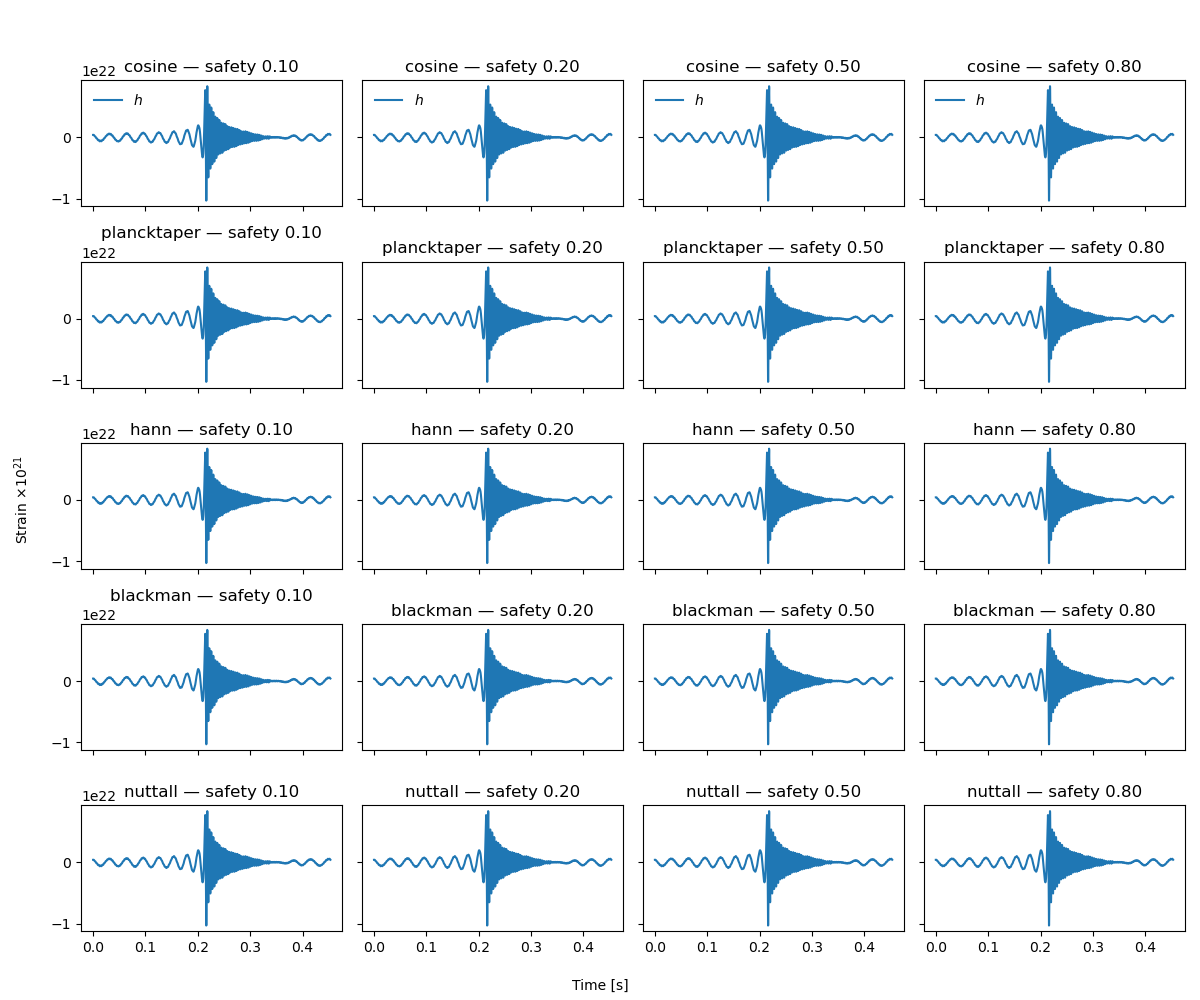

In [15]:
# Plot some of the tapered injections
# also plot the untapered data

n_rows = len(window_funcs)
n_cols = len(safeties)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(3 * n_cols, 2 * n_rows), sharex=True, sharey=True)

# Ensure axes is 2D
axes = np.atleast_2d(axes)
    
for i, func in enumerate(window_funcs):
    for j, safety in enumerate(safeties):
        ax = axes[i, j]
        h = tapered_injection_dict[(safety, func, 'L1')][1]
        times = tapered_injection_dict[(safety, func, 'L1')][0]
        ax.plot(times, 1e21 * h, '-', label=r'$h$')
        ax.set_title(f"{func} — safety {safety:.2f}")
        #ax.set_xlim(times[0], times[-1])
        if i == 0:
            ax.legend(loc='upper left', frameon=False, ncols=2)

# common labels
fig.text(0.5, 0.01, "Time [s]", ha='center')
fig.text(0.01, 0.5, r"Strain $\times 10^{21}$", va='center', rotation='vertical')
plt.tight_layout(rect=[0.03, 0.03, 1, 0.97])
plt.show()